In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
# Read the list of molecules
molecules = pd.read_excel("data/gain-synonyms-list.xlsx")

In [4]:
molecules_list = list(molecules['Gain'].str.lower())
# selected_molecules = [m.split(" ")[-1] for m in molecules_list[0:7000] if (("+" not in m) and 

selected_molecules = [m.split(" ")[-1] for m in molecules_list[0:7000] if (("+" not in m) and 
                      (m.endswith("olol") or 
                      m.endswith('cillin') or 
                      m.endswith('sartan') or 
                      m.endswith('mycin') or 
                      m.endswith('vir') or 
                      m.endswith('parin') or
                      m.endswith('mab') or 
                      m.endswith('lamide') or
                      m.endswith('caine') or
                      m.endswith('bital') or
                      m.endswith('afil') or
                      m.endswith('asone') or
                      m.endswith('profen') or 
                      m.endswith('statin') or
                      m.endswith('tinib')))]

In [69]:
selected_molecules = list(set(selected_molecules))
len(selected_molecules)

196

In [71]:
selected_molecules[:50]

['ampicillin',
 'acalabrutinib',
 'telaprevir',
 'sultamicillin',
 'natalizumab',
 'ganciclovir',
 'valsartan',
 'imatinib',
 'candesartan',
 'pemigatinib',
 'lorlatinib',
 'bleomycin',
 'binimetinib',
 'fostemsavir',
 'dexketoprofen',
 'mepolizumab',
 'telmisartan',
 'olmesartan',
 'benzocaine',
 'nadolol',
 'fluvastatin',
 'timolol',
 'carteolol',
 'dolutegravir',
 'ponatinib',
 'fedratinib',
 'tucatinib',
 'penciclovir',
 'afatinib',
 'nebivolol',
 'atazanavir',
 'alirocumab',
 'clobetasone',
 'piperacillin',
 'raltegravir',
 'fostamatinib',
 'neomycin',
 'ibrutinib',
 'glecaprevir',
 'metoprolol',
 'prilocaine',
 'ibuprofen',
 'upadacitinib',
 'flucloxacillin',
 'cabozantinib',
 'avapritinib',
 'levobunolol',
 'roxithromycin',
 'penbutolol',
 'lidocaine']

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch as torch

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [66]:
#embeddings and cosines
mat = np.zeros([len(selected_molecules), 768])
i=0
print("Computing embeddings...")
for drug in selected_molecules:
    inputs = tokenizer.encode(drug, return_tensors="pt")
    with torch.no_grad():
        last_hidden_states = model(inputs)[0] # Models outputs are now tuples
        last_hidden_states = last_hidden_states.mean(1)
        mat[i,:] = last_hidden_states
        i+=1
print("Computing cosines...")
dist_out = 1-pairwise_distances(mat, metric="cosine")
dist_out

Computing embeddings...
Computing cosines...


array([[1.        , 0.86633927, 0.93455955, ..., 0.87701651, 0.92625845,
        0.90167808],
       [0.86633927, 1.        , 0.87708322, ..., 0.87340261, 0.85912274,
        0.89560609],
       [0.93455955, 0.87708322, 1.        , ..., 0.85643659, 0.88483231,
        0.88429627],
       ...,
       [0.87701651, 0.87340261, 0.85643659, ..., 1.        , 0.88795311,
        0.92344166],
       [0.92625845, 0.85912274, 0.88483231, ..., 0.88795311, 1.        ,
        0.89520139],
       [0.90167808, 0.89560609, 0.88429627, ..., 0.92344166, 0.89520139,
        1.        ]])

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
Z = linkage(mat, metric = 'cosine', method = 'single')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


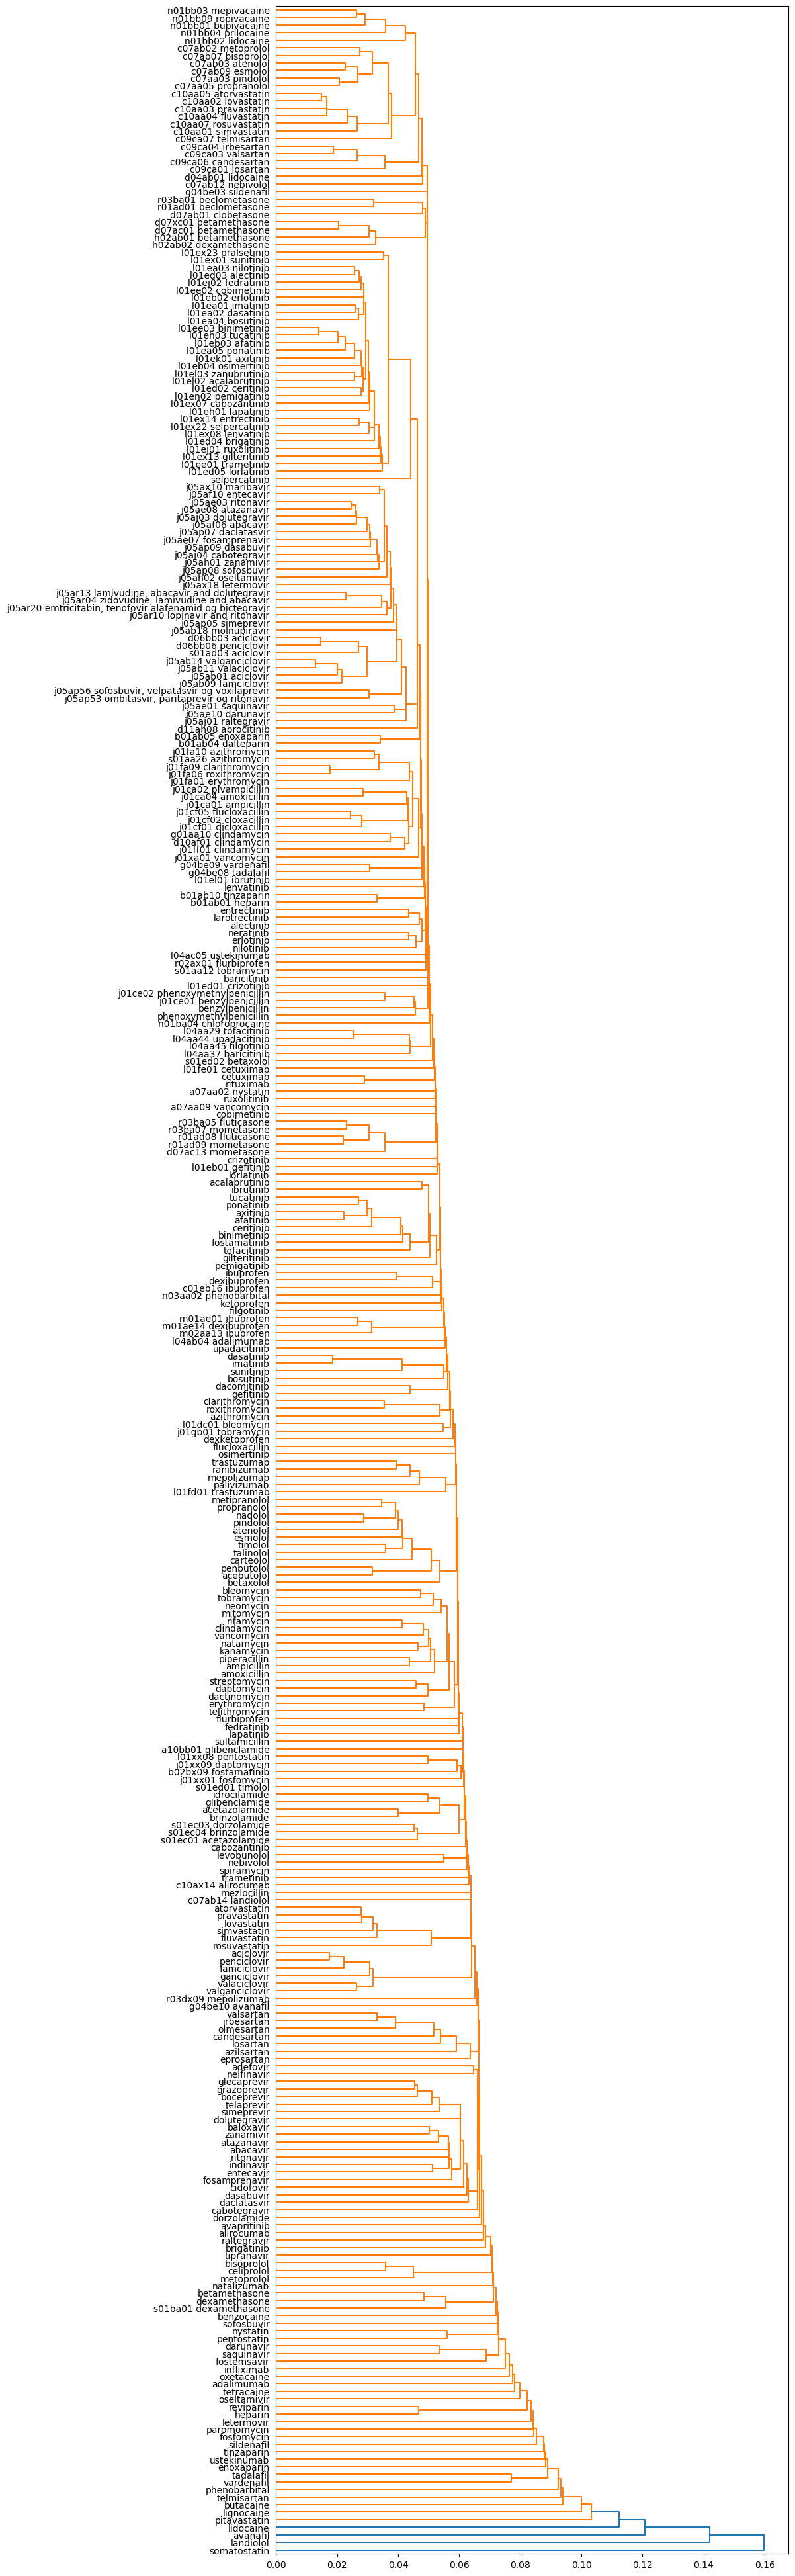

In [68]:
fig = plt.figure(figsize=(10, 50))
# dn = dendrogram(Z)
dendrogram(
            Z,
            orientation='right',
            labels=selected_molecules,
#             distance_sort='descending',
#             show_leaf_counts=False
          )
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.show()

In [69]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(distance_threshold=0.06,
                                               n_clusters = None,
                                               affinity='cosine', 
                                               linkage='single',
                                               compute_distances = True)
labels = hierarchical_cluster.fit_predict(mat)


/Users/ariellubonja/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [70]:
labels

array([ 0,  5,  0, 66, 55, 50,  0,  0,  0,  0,  0,  4,  0,  0, 49, 13,  0,
        0, 11,  0,  0, 57,  0,  0, 43,  0,  0,  0,  0,  0,  0,  0, 61,  0,
        0,  7, 34,  0,  0,  0,  0,  0,  0,  7,  0, 45,  0,  2,  2,  0, 44,
        0,  0,  0,  2, 60, 13,  0,  4,  0,  0,  0, 11,  3, 39,  0,  0, 37,
       54,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 64,  0,  0,  0,  0,
        0, 41,  0,  0,  0,  0, 63,  0,  0,  4,  0, 62,  0, 56,  0, 35,  0,
        0,  0,  4,  0,  0,  0,  0,  0,  0,  1,  0, 38, 58,  0,  0,  0,  0,
        0,  0,  0, 28, 46,  0,  0,  0, 21,  0,  0,  0,  5, 27,  0,  0,  3,
        0,  0, 28,  0,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,  0, 47,  0,
       33, 13, 16,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       14,  0, 11,  0, 11,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
       59,  9,  0,  0, 24,  0,  4,  9, 22,  0,  3,  0,  0,  0,  6,  0, 36,
       14,  0, 10,  0,  0, 29,  0,  0,  0, 17, 65,  3,  0, 10,  0,  0,  0,
       42,  0,  0, 20, 48

In [71]:
for i in set(labels):
    print([selected_molecules[j] for j in range(len(selected_molecules)) if labels[j]==i])
    # print("\n")

['l01en02 pemigatinib', 'pemigatinib', 'j01ca04 amoxicillin', 'l01ed03 alectinib', 'j05ar10 lopinavir and ritonavir', 'palivizumab', 'roxithromycin', 'n01ba04 chloroprocaine', 'c07aa05 propranolol', 'ampicillin', 'n01bb01 bupivacaine', 'osimertinib', 'l01ex01 sunitinib', 'j01cf02 cloxacillin', 'tobramycin', 'n03aa02 phenobarbital', 'b01ab01 heparin', 'mepolizumab', 'j01cf05 flucloxacillin', 'l01eh03 tucatinib', 'l01ex23 pralsetinib', 'c09ca03 valsartan', 's01ed02 betaxolol', 'lenvatinib', 'c07ab09 esmolol', 'j01ca01 ampicillin', 'lorlatinib', 'dexibuprofen', 'l01eb01 gefitinib', 'j05ab11 valaciclovir', 'j05ah02 oseltamivir', 'flucloxacillin', 'c10aa04 fluvastatin', 'nilotinib', 'n01bb02 lidocaine', 'l01el02 acalabrutinib', 'l04aa45 filgotinib', 'd04ab01 lidocaine', 'j05ae08 atazanavir', 'c09ca06 candesartan', 'd11ah08 abrocitinib', 'esmolol', 'j01fa06 roxithromycin', 'd06bb06 penciclovir', 'h02ab02 dexamethasone', 'baricitinib', 'dexketoprofen', 'h02ab01 betamethasone', 'j05ar04 zidovu

In [73]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 20)
 
mat_small = pca.fit_transform(mat)

Y = linkage(mat_small, metric = 'cosine', method = 'single', optimal_ordering=True)

In [75]:
mat_small.shape

(337, 20)

In [76]:
Y.shape

(336, 4)

In [74]:
Y[:10]

array([[7.00000000e+01, 2.38000000e+02, 2.08655463e-02, 2.00000000e+00],
       [1.30000000e+01, 1.24000000e+02, 2.38668097e-02, 2.00000000e+00],
       [2.17000000e+02, 2.70000000e+02, 2.57155408e-02, 2.00000000e+00],
       [3.24000000e+02, 4.20000000e+01, 3.18278401e-02, 2.00000000e+00],
       [3.10000000e+01, 6.10000000e+01, 3.42215285e-02, 2.00000000e+00],
       [1.50000000e+02, 9.00000000e+01, 3.56454383e-02, 2.00000000e+00],
       [2.49000000e+02, 3.41000000e+02, 3.69041460e-02, 3.00000000e+00],
       [1.42000000e+02, 2.45000000e+02, 3.88707663e-02, 2.00000000e+00],
       [3.39000000e+02, 2.50000000e+02, 3.97180103e-02, 3.00000000e+00],
       [1.09000000e+02, 1.92000000e+02, 3.99937198e-02, 2.00000000e+00]])

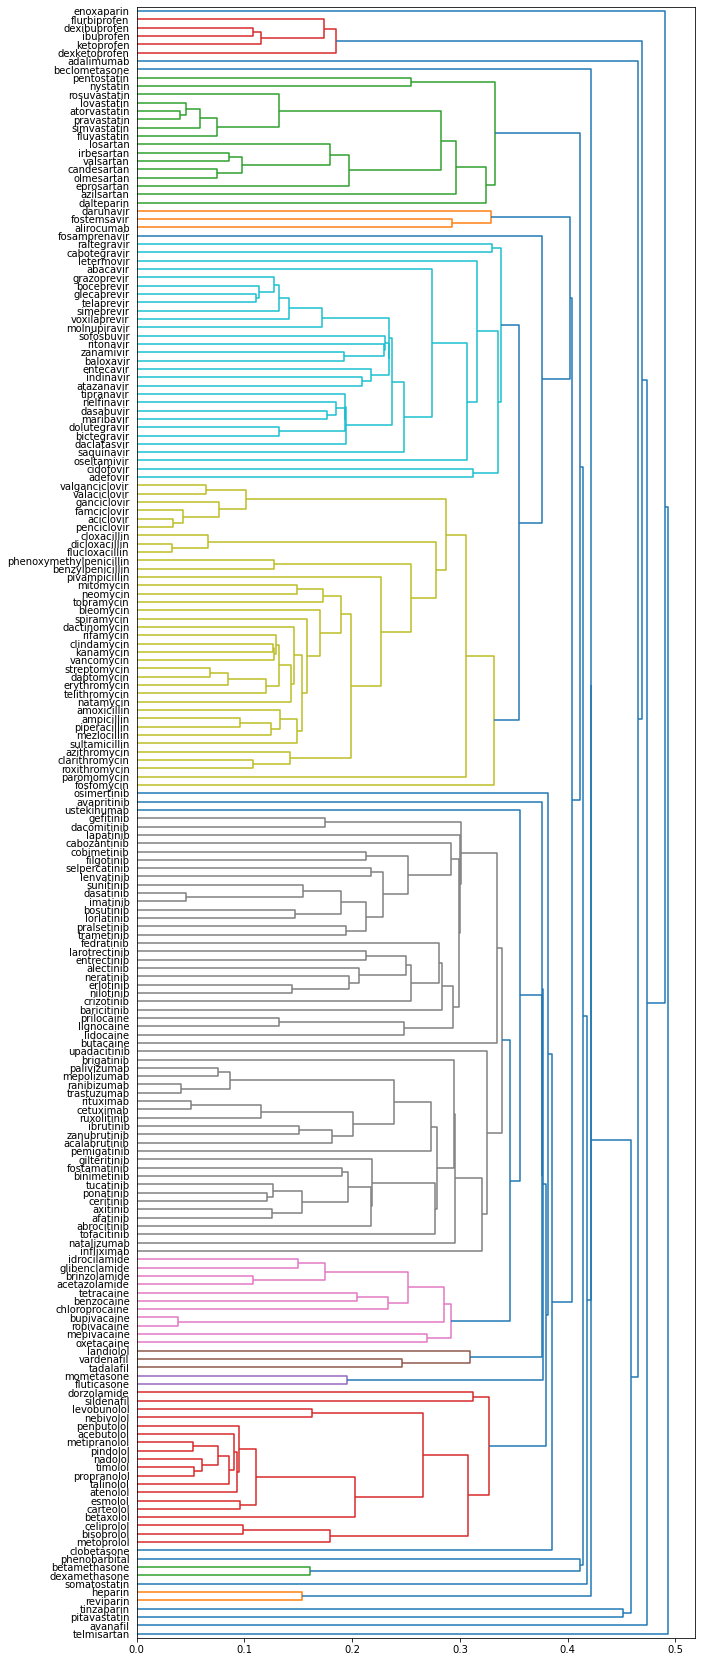

In [145]:
fig = plt.figure(figsize=(10, 30))
# dn = dendrogram(Z)
dendrogram(
            Y,
            orientation='right',
            labels=selected_molecules
#             distance_sort='descending',
#             show_leaf_counts=False
          )
plt.yticks(size = 10)
plt.xticks(size = 10)
plt.show()

# LLM embeddings

1. Llama
2. Saudi thing (Falcon?)

# TODO Use Drug Class from Drugs.com as ground truth

In [45]:
# https://python.langchain.com/docs/modules/data_connection/text_embedding/integrations/llamacpp

from langchain.embeddings import LlamaCppEmbeddings

In [46]:
# I got GGML from here https://huggingface.co/Pi3141/alpaca-native-7B-ggml/tree/397e872bf4c83f4c642317a5bf65ce84a105786e
# Need llama-cpp-python=0.1.48 for this to work
llama = LlamaCppEmbeddings(model_path="models/ggml-model-q4_0.bin")

llama.cpp: loading model from models/ggml-model-q4_0.bin
llama.cpp: can't use mmap because tensors are not aligned; convert to new format to avoid this
llama_model_load_internal: format     = 'ggml' (old version with low tokenizer quality and no mmap support)
llama_model_load_internal: n_vocab    = 32000
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 2 (mostly Q4_0)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size = 4113748.20 KB
llama_model_load_internal: mem required  = 5809.33 MB (+ 2052.00 MB per state)
...................................................................................................
.
llama_

In [47]:
llama_embeddings = []

for drug in selected_molecules:
    llama_embeddings.append(np.array(llama.embed_query(drug)))

llama_embeddings = np.array(llama_embeddings)


llama_print_timings:        load time =   329.81 ms
llama_print_timings:      sample time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings: prompt eval time =   554.50 ms /    12 tokens (   46.21 ms per token)
llama_print_timings:        eval time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings:       total time =   559.23 ms

llama_print_timings:        load time =   329.81 ms
llama_print_timings:      sample time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings: prompt eval time =   229.56 ms /     5 tokens (   45.91 ms per token)
llama_print_timings:        eval time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings:       total time =   231.93 ms

llama_print_timings:        load time =   329.81 ms
llama_print_timings:      sample time =     0.00 ms /     1 runs   (    0.00 ms per run)
llama_print_timings: prompt eval time =   212.78 ms /     4 tokens (   53.19 ms per token)
llama_print_timings

In [48]:
llama_embeddings.shape

(337, 4096)

In [49]:
df_embeddings = pd.DataFrame(llama_embeddings, index=selected_molecules)
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
natalizumab,2.828465,-0.323880,0.461534,1.198783,0.935547,0.000823,0.155675,-0.988050,-1.114025,-0.150321,...,0.569156,0.244178,1.626112,0.391793,-3.204831,2.612899,-0.117829,-0.720186,-1.816628,0.691926
m01ae01 ibuprofen,1.074838,0.657038,1.360706,-5.513775,-1.665575,2.625445,0.869148,0.339563,-0.072241,2.003556,...,1.324995,0.487249,0.127595,-2.022812,0.551745,-1.475831,1.101082,-0.874682,-0.473008,1.664385
c10aa07 rosuvastatin,1.518491,-2.513644,0.669459,-1.918136,0.803508,1.091942,0.397057,-0.792143,-0.150410,-1.392565,...,1.292354,-0.403158,0.155575,0.822154,-1.084596,-2.158307,1.151778,0.199070,-0.627960,-0.777577
candesartan,0.846399,-1.726462,0.906651,-1.306898,0.193972,0.240104,0.303152,-1.743013,-1.192302,-1.672895,...,0.621502,-0.167140,0.252433,0.113513,-1.079827,-0.638547,1.297506,0.620969,0.505722,-1.139408
pemigatinib,1.657495,-1.523324,0.316984,0.202013,-0.703365,0.021658,-1.032712,-1.622851,0.565182,-2.019764,...,0.295195,-0.309789,-1.277183,0.816564,-0.307367,1.484333,0.583064,0.173681,-1.643754,0.549972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
j01fa01 erythromycin,1.423937,-1.464059,1.342668,-2.036792,-0.269410,0.041910,-1.230801,1.151237,-0.480988,-1.620400,...,0.861181,0.016938,-0.292618,0.285136,-0.866278,-2.114719,0.906899,-2.181357,-1.457417,-1.947545
tinzaparin,2.228670,-0.159228,-0.109560,-5.730936,0.579347,1.020371,-0.223716,0.250876,-2.003304,0.236973,...,-0.811422,0.179909,-0.026103,-1.260885,-0.783256,-2.187079,1.265969,-0.064035,-0.880782,0.242898
butacaine,2.518704,-0.942618,0.123301,-2.494893,0.742145,1.234087,-2.008594,-0.561873,-1.676916,-0.065500,...,0.186027,1.469089,1.468835,1.642494,-0.365990,-0.160554,1.155843,-0.724900,-0.382189,0.103708
talinolol,-0.027222,0.328401,0.359490,-3.381045,-1.882977,-0.942354,-1.354775,-2.391139,-1.751019,-0.745730,...,0.987279,1.469541,1.499256,0.138259,-2.046890,1.591194,-1.156546,0.415519,-1.736278,-0.914798


## Save embeddings to file

In [50]:
df_embeddings.to_csv("outputs/llama-embeddings.csv", index_label="Drug Name")

## Load embeddings from file

In [9]:
df_embeddings = pd.read_csv("outputs/llama-embeddings.csv", index_col="Drug Name")
df_embeddings

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
Drug Name,,,,,,,,,,,,,,,,,,,,,
j05af10 entecavir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
entrectinib,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
l04aa45 filgotinib,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
g04be08 tadalafil,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
s01ba01 dexamethasone,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oseltamivir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
dolutegravir,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237
dexketoprofen,3.030608,0.668737,1.2298,-6.182161,-0.812407,1.275752,0.430807,1.837162,-0.249098,1.199062,...,0.526793,0.69801,0.94362,-2.227502,1.127113,-2.115299,2.002693,-1.047605,-0.305849,2.522237


### Put all pairwise similarities in a 2D matrix

In [51]:
Y = linkage(df_embeddings, metric = 'euclidean', method = 'single', optimal_ordering=True)
Y

array([[  1.        , 116.        ,  18.70123473,   2.        ],
       [204.        , 278.        ,  22.63760263,   2.        ],
       [337.        , 218.        ,  23.01140064,   3.        ],
       ...,
       [669.        ,  24.        ,  82.24903076, 335.        ],
       [670.        , 136.        ,  85.91025585, 336.        ],
       [ 37.        , 671.        ,  86.48871613, 337.        ]])

In [53]:
normalized_embeddings = df_embeddings.values / np.linalg.norm(df_embeddings.values, axis=1)[:, None]
# normalized_embeddings

In [62]:
from scipy.cluster.hierarchy import linkage, dendrogram

def show_dendrogram_from_embeddings(embeddings_matrix, selected_molecules):
    fig = plt.figure(figsize=(10, 50))

    Y = linkage(embeddings_matrix, metric = 'cosine', method = 'complete', optimal_ordering=True)

    dendrogram(
                Y,
                orientation='right',
                labels=selected_molecules
            )
    plt.yticks(size = 10)
    plt.xticks(size = 10)
    plt.show()

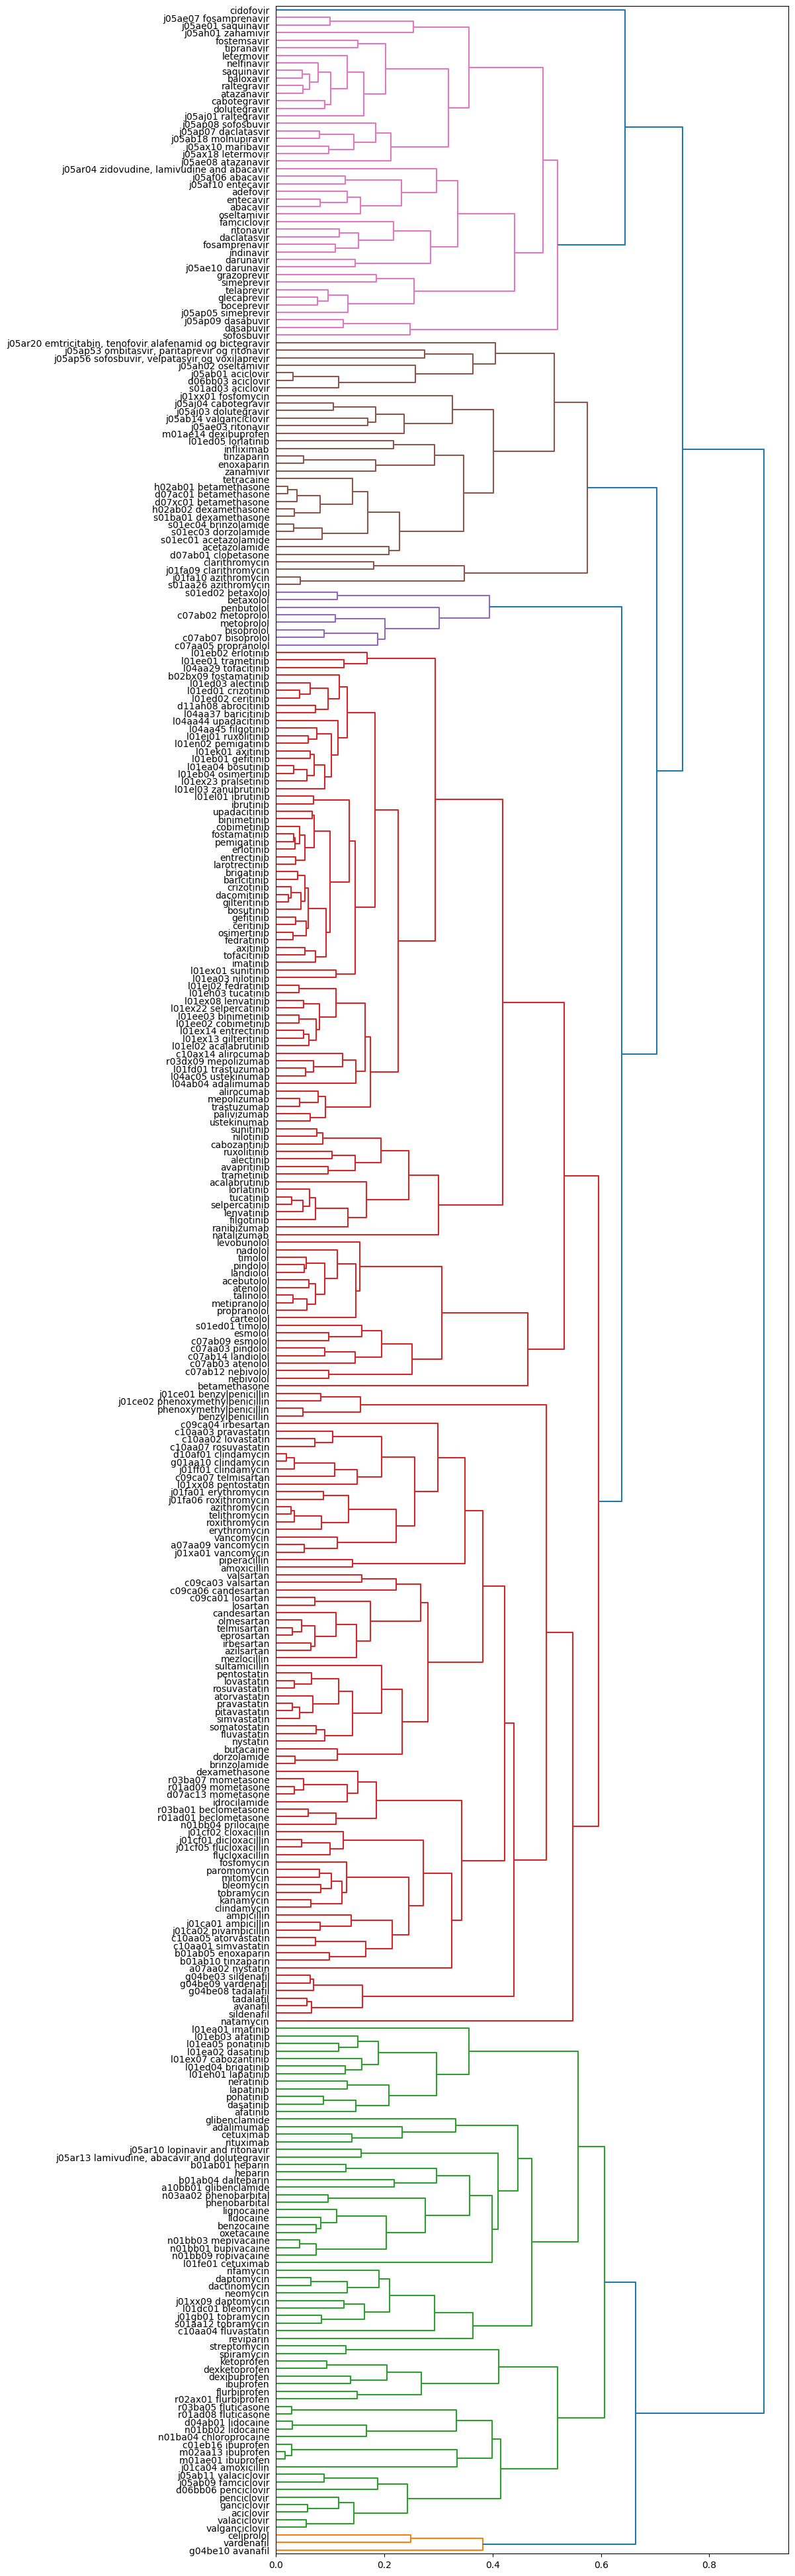

In [63]:
show_dendrogram_from_embeddings(df_embeddings.values, selected_molecules)

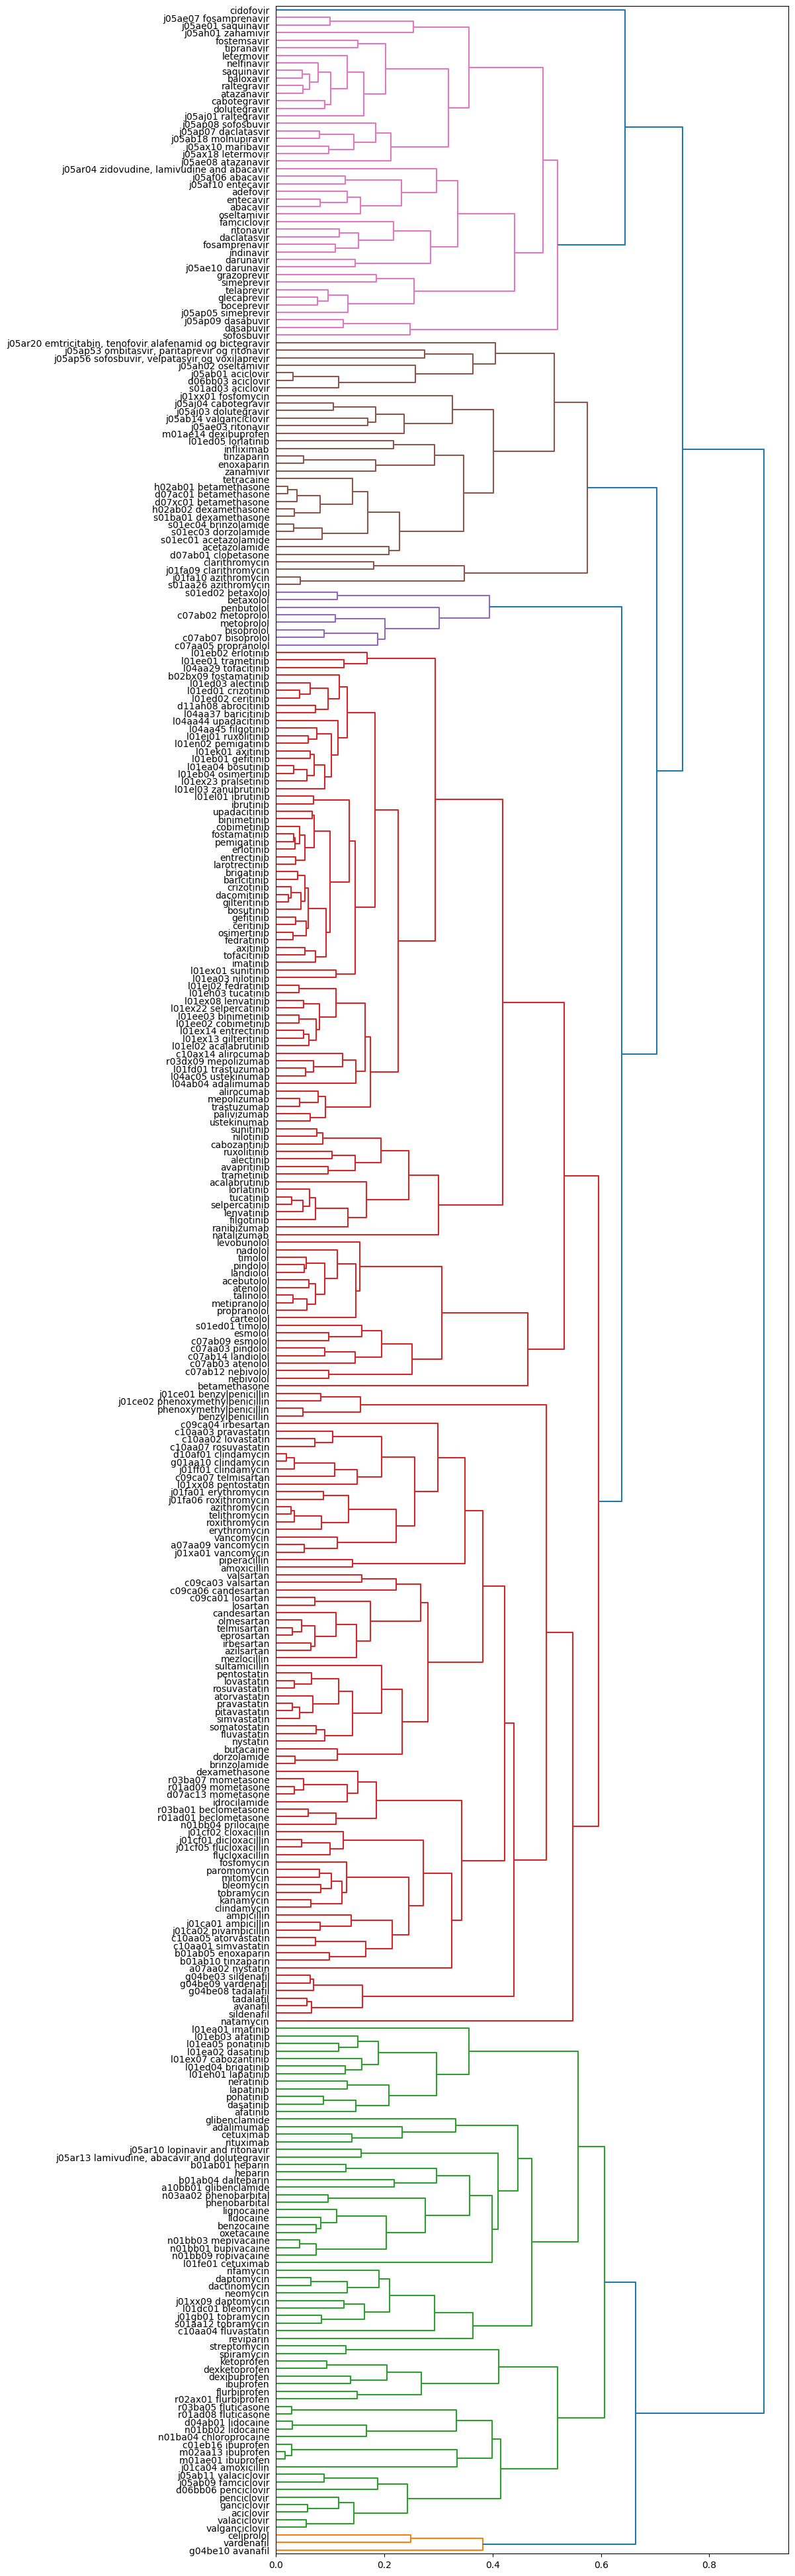

In [64]:
show_dendrogram_from_embeddings(normalized_embeddings, selected_molecules)

# Verifying embeddings by comparing them to Drug Class from Drugs.com data


TODO
1. Match drug names between Drugs.com and CSV file
2. Count how many drugs match perfectly
3. Extract Drug Class from HTML files
4. Use as ground truth to evaluate embeddings

1. Match drug names between Drugs.com and CSV file
2. Count how many drugs match perfectly

In [6]:
from utils import html_tools

In [6]:
drugs_com_drug_names = html_tools.get_unique_drugs()
list(drugs_com_drug_names)[:10]

['soothe-caplets',
 'proctocort-cream',
 'asacol-800',
 'premarin-injection',
 'junel',
 'bacitracin-ophthalmic',
 'trazodone',
 'vasopressin',
 'apo-amoxi-clav',
 'definity']

In [7]:
# Intersection of drugs.com and CSV dataset by Drug Name
intersection = set(selected_molecules).intersection(drugs_com_drug_names)

print("There are", len(intersection), "drugs that match between Drugs.com and the CSV dataset")
print(intersection)

There are 112 drugs that match between Drugs.com and the CSV dataset
{'baloxavir', 'metoprolol', 'tucatinib', 'telaprevir', 'piperacillin', 'fluvastatin', 'acebutolol', 'larotrectinib', 'valganciclovir', 'baricitinib', 'cetuximab', 'atorvastatin', 'entrectinib', 'tofacitinib', 'ketoprofen', 'mepivacaine', 'ponatinib', 'trametinib', 'imatinib', 'amoxicillin', 'enoxaparin', 'neomycin', 'dexamethasone', 'pentostatin', 'dalteparin', 'entecavir', 'maribavir', 'valsartan', 'ibrutinib', 'azithromycin', 'clarithromycin', 'avanafil', 'bisoprolol', 'cidofovir', 'avapritinib', 'lovastatin', 'adalimumab', 'mitomycin', 'clindamycin', 'pindolol', 'abrocitinib', 'natalizumab', 'atenolol', 'daptomycin', 'pravastatin', 'cabotegravir', 'erythromycin', 'ganciclovir', 'mometasone', 'bosutinib', 'irbesartan', 'levobunolol', 'telithromycin', 'raltegravir', 'zanamivir', 'nilotinib', 'selpercatinib', 'nebivolol', 'oseltamivir', 'rosuvastatin', 'penciclovir', 'molnupiravir', 'propranolol', 'ruxolitinib', 'nado

<font color="orange">3. Extract Drug Class from HTML files</font>

In [8]:
drugs_html = html_tools.get_all_drugs_html("data/drugs/")

In [8]:
len(drugs_html)

15636

In [9]:
# This took 4min 45s to run on Macbook M1 Pro
# TODO parallelize?

drugs_and_classes = {}
for drug in drugs_html:
    # print(drug)
    drug_class = html_tools.get_drug_class_name(drugs_html[drug], print_warnings=False)
    if drug_class is not None:
        drugs_and_classes[drug] = drug_class[0]

In [10]:
drugs_and_classes

{'https:$$www.drugs.com$ella.html': 'Progesterone receptor modulators',
 'https:$$www.drugs.com$mtm$pancreatin.html': 'Digestive enzymes',
 'https:$$www.drugs.com$mtm$boroleum.html': 'Topical rubefacient',
 'https:$$www.drugs.com$benicar.html': 'Angiotensin receptor blockers',
 'https:$$www.drugs.com$mtm$duac.html': 'Topical acne agents',
 'https:$$www.drugs.com$cons$centany-topical.html': 'Topical antibiotics',
 'https:$$www.drugs.com$trizivir.html': 'Antiviral combinations',
 'https:$$www.drugs.com$pro$levulan-kerastick.html': 'Topical photochemotherapeutics',
 'https:$$www.drugs.com$mtm$codar-gf.html': 'Upper respiratory combinations',
 'https:$$www.drugs.com$arranon.html': 'Antimetabolites',
 'https:$$www.drugs.com$veltin.html': 'Topical acne agents',
 'https:$$www.drugs.com$cons$novamoxin-reduced-sugar-oral-injection-intravenous-intramuscular.html': 'Natural penicillins',
 'https:$$www.drugs.com$teflaro.html': 'Next generation cephalosporins',
 'https:$$www.drugs.com$pro$pemetrexe

In [17]:
df = pd.DataFrame(drugs_and_classes.values(), index=drugs_and_classes.keys())
df

,0
https:$$www.drugs.com$ella.html,Progesterone receptor modulators
https:$$www.drugs.com$mtm$pancreatin.html,Digestive enzymes
https:$$www.drugs.com$mtm$boroleum.html,Topical rubefacient
https:$$www.drugs.com$benicar.html,Angiotensin receptor blockers
https:$$www.drugs.com$mtm$duac.html,Topical acne agents
...,...
https:$$www.drugs.com$cons$acne-10-gel-topical.html,Topical acne agents
https:$$www.drugs.com$lorbrena.html,Multikinase inhibitors
https:$$www.drugs.com$mtm$halcion.html,Benzodiazepines
https:$$www.drugs.com$pro$desmopressin-nasal-spray.html,Antidiuretic hormones


In [12]:
# Replace the weird URL with the drug name
new_index = [html_tools.replace_url_w_drug_name(key) for key in df.index]

df.index = new_index

list

In [21]:
df = df.rename(columns={0: "Drug Class"})
df.index.name = "Drug URL"
df

,Drug Class
Drug URL,
https:$$www.drugs.com$ella.html,Progesterone receptor modulators
https:$$www.drugs.com$mtm$pancreatin.html,Digestive enzymes
https:$$www.drugs.com$mtm$boroleum.html,Topical rubefacient
https:$$www.drugs.com$benicar.html,Angiotensin receptor blockers
https:$$www.drugs.com$mtm$duac.html,Topical acne agents
...,...
https:$$www.drugs.com$cons$acne-10-gel-topical.html,Topical acne agents
https:$$www.drugs.com$lorbrena.html,Multikinase inhibitors
https:$$www.drugs.com$mtm$halcion.html,Benzodiazepines


In [16]:
# df.to_csv("outputs/drug-classes.csv")

In [2]:
drug_classes_df = pd.read_csv("outputs/drug-classes.csv", index_col="Drug URL")
drug_classes_df

,Drug Class
Drug URL,
https:$$www.drugs.com$ella.html,Progesterone receptor modulators
https:$$www.drugs.com$mtm$pancreatin.html,Digestive enzymes
https:$$www.drugs.com$mtm$boroleum.html,Topical rubefacient
https:$$www.drugs.com$benicar.html,Angiotensin receptor blockers
https:$$www.drugs.com$mtm$duac.html,Topical acne agents
...,...
https:$$www.drugs.com$cons$acne-10-gel-topical.html,Topical acne agents
https:$$www.drugs.com$lorbrena.html,Multikinase inhibitors
https:$$www.drugs.com$mtm$halcion.html,Benzodiazepines
